In [1]:
from google.colab import drive

# Check if the mountpoint directory already exists and is not empty
import os
if os.path.exists('/content/drive') and os.listdir('/content/drive'):
  # If it exists and is not empty, suggest clearing it or using a different mountpoint
  print("The directory '/content/drive' is not empty. Please clear its contents or choose a different mountpoint.")
else:
  # If it doesn't exist or is empty, proceed with mounting
  drive.mount('/content/drive')


Mounted at /content/drive


# **Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Input, Resizing, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# **Constants**

In [3]:
dataset_dir = '/content/drive/MyDrive/Data/Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

# **Importing dataset into tensorflow dataset object**

In [4]:
# Generating a tf.data.Dataset from image files in the directory. 3 classes since we have 3 folders - Early Blight, Late Blight and Healthy
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [6]:
# Printing the number of iterations to go through the entire dataset
# Total Num of images - (len(dataset)*BATCH_SIZE)
dataset_size = len(dataset)
print(dataset_size)

68


In [7]:
# Printing the dimensions of the first batch of images and their corresponding labels
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) # Converting tensor to numpy

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [8]:
# Printing the dimensions of all the images in the dataset
index = 1
for image_batch, label_batch in dataset:
    for image in image_batch:
        height, width, channels = image.shape
        print(f"{index}. Height: {height}, Width: {width}")
        index += 1

1. Height: 256, Width: 256
2. Height: 256, Width: 256
3. Height: 256, Width: 256
4. Height: 256, Width: 256
5. Height: 256, Width: 256
6. Height: 256, Width: 256
7. Height: 256, Width: 256
8. Height: 256, Width: 256
9. Height: 256, Width: 256
10. Height: 256, Width: 256
11. Height: 256, Width: 256
12. Height: 256, Width: 256
13. Height: 256, Width: 256
14. Height: 256, Width: 256
15. Height: 256, Width: 256
16. Height: 256, Width: 256
17. Height: 256, Width: 256
18. Height: 256, Width: 256
19. Height: 256, Width: 256
20. Height: 256, Width: 256
21. Height: 256, Width: 256
22. Height: 256, Width: 256
23. Height: 256, Width: 256
24. Height: 256, Width: 256
25. Height: 256, Width: 256
26. Height: 256, Width: 256
27. Height: 256, Width: 256
28. Height: 256, Width: 256
29. Height: 256, Width: 256
30. Height: 256, Width: 256
31. Height: 256, Width: 256
32. Height: 256, Width: 256
33. Height: 256, Width: 256
34. Height: 256, Width: 256
35. Height: 256, Width: 256
36. Height: 256, Width: 256
3

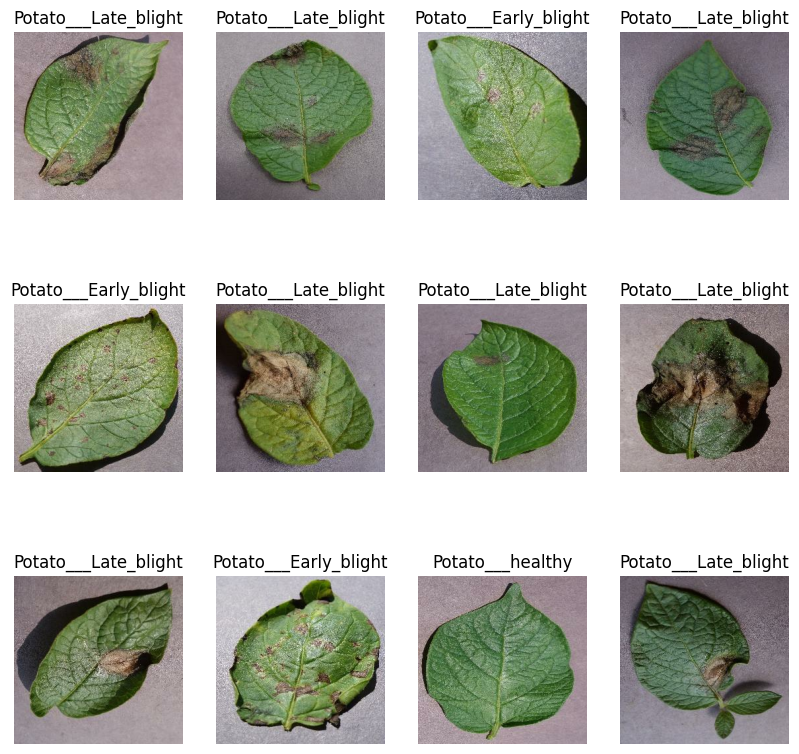

In [9]:
# Dispalying the first 12 images fro the first batch of the dataset

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **Splitting the Dataset**

In [10]:
# Function for splitting the dataset into 80% train, 10% validation and 10% test sets
def get_dataset_splits(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert (train_split + test_split + validation_split) == 1

  if shuffle:
    dataset = dataset.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * dataset_size)
  validation_size = int(validation_split * dataset_size)

  train_dataset = dataset.take(train_size)
  validation_dataset = dataset.skip(train_size).take(validation_size)
  test_dataset = dataset.skip(train_size).skip(validation_size)

  return train_dataset, validation_dataset, test_dataset

train_dataset, validation_dataset, test_dataset = get_dataset_splits(dataset)
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

54
6
8


# **Caching, Shuffling and prefetching the dataset**

In [11]:
# These transformations reduce the training time (cache), improve model performance (shuffle) and optimize the hardware usage (prefetch)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Data Preprocessing**

In [12]:
# Data Augmentation to improve generalizability
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2)
])

In [14]:
# Applying data augmentation to the training dataset
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Model Architecture**

In [15]:
num_classes = 3

# Define the model
model = models.Sequential([
    # Input layer
    Input(shape=(None, None, CHANNELS)),

    # Preprocessing layers - resizes the images to 256*256 and rescales the pixels for normalization
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),

    # Convolutional layers - Total 6 Layers
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

# Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 825ms/step - accuracy: 0.4730 - loss: 0.9692 - val_accuracy: 0.5260 - val_loss: 0.9133
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 640ms/step - accuracy: 0.5352 - loss: 0.8388 - val_accuracy: 0.7448 - val_loss: 0.5508
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 634ms/step - accuracy: 0.7682 - loss: 0.5342 - val_accuracy: 0.8229 - val_loss: 0.3883
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 667ms/step - accuracy: 0.8620 - loss: 0.3488 - val_accuracy: 0.8177 - val_loss: 0.4197
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 629ms/step - accuracy: 0.8804 - loss: 0.3141 - val_accuracy: 0.9427 - val_loss: 0.1916
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 654ms/step - accuracy: 0.9229 - loss: 0.2404 - val_accuracy: 0.7969 - val_loss: 0.6576
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 641ms/step - accuracy: 0.8914 - loss: 0.2655 - val_accuracy: 0.9375 - val_loss: 0.1419
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 645ms/step - accuracy: 0.9357 - loss: 0.1662 - val_accu

# **Testing the Model**

In [18]:
# Function to test the models
def test_model(model, test_dataset):
    test_loss, test_acc = model.evaluate(test_dataset)
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)

test_model(model, test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9584 - loss: 0.1139
Test loss: 0.10136152803897858
Test accuracy: 0.96484375


# **Plotting Loss and Accuracy Curves**

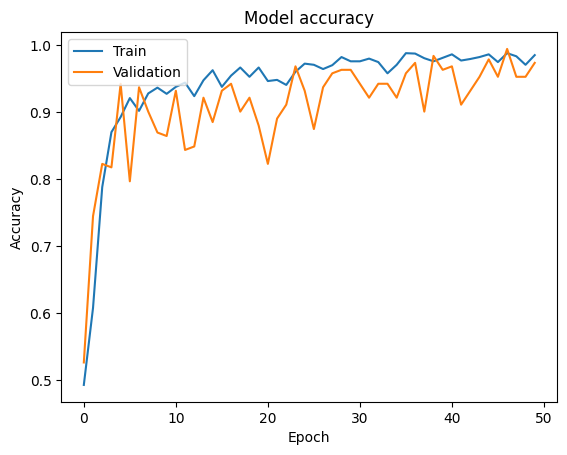

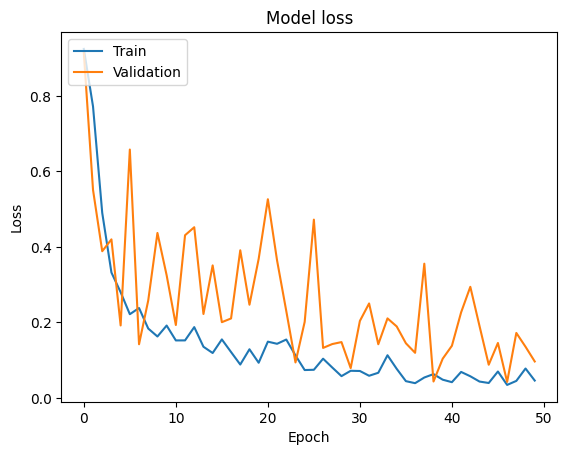

In [19]:
# Function to plot training and validation accuracy and loss
def loss_and_accuracy_plots(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

loss_and_accuracy_plots(history)

# **Predictions**

First Image:
Actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted label: Potato___healthy


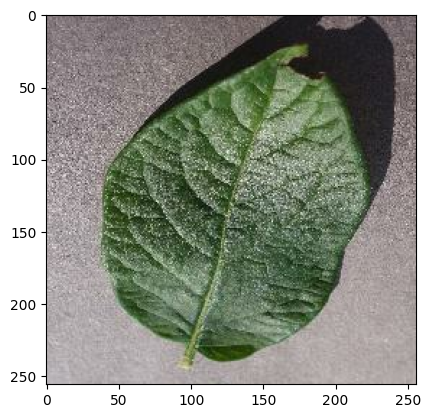

In [25]:
for images_batch, labels_batch in test_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First Image:")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


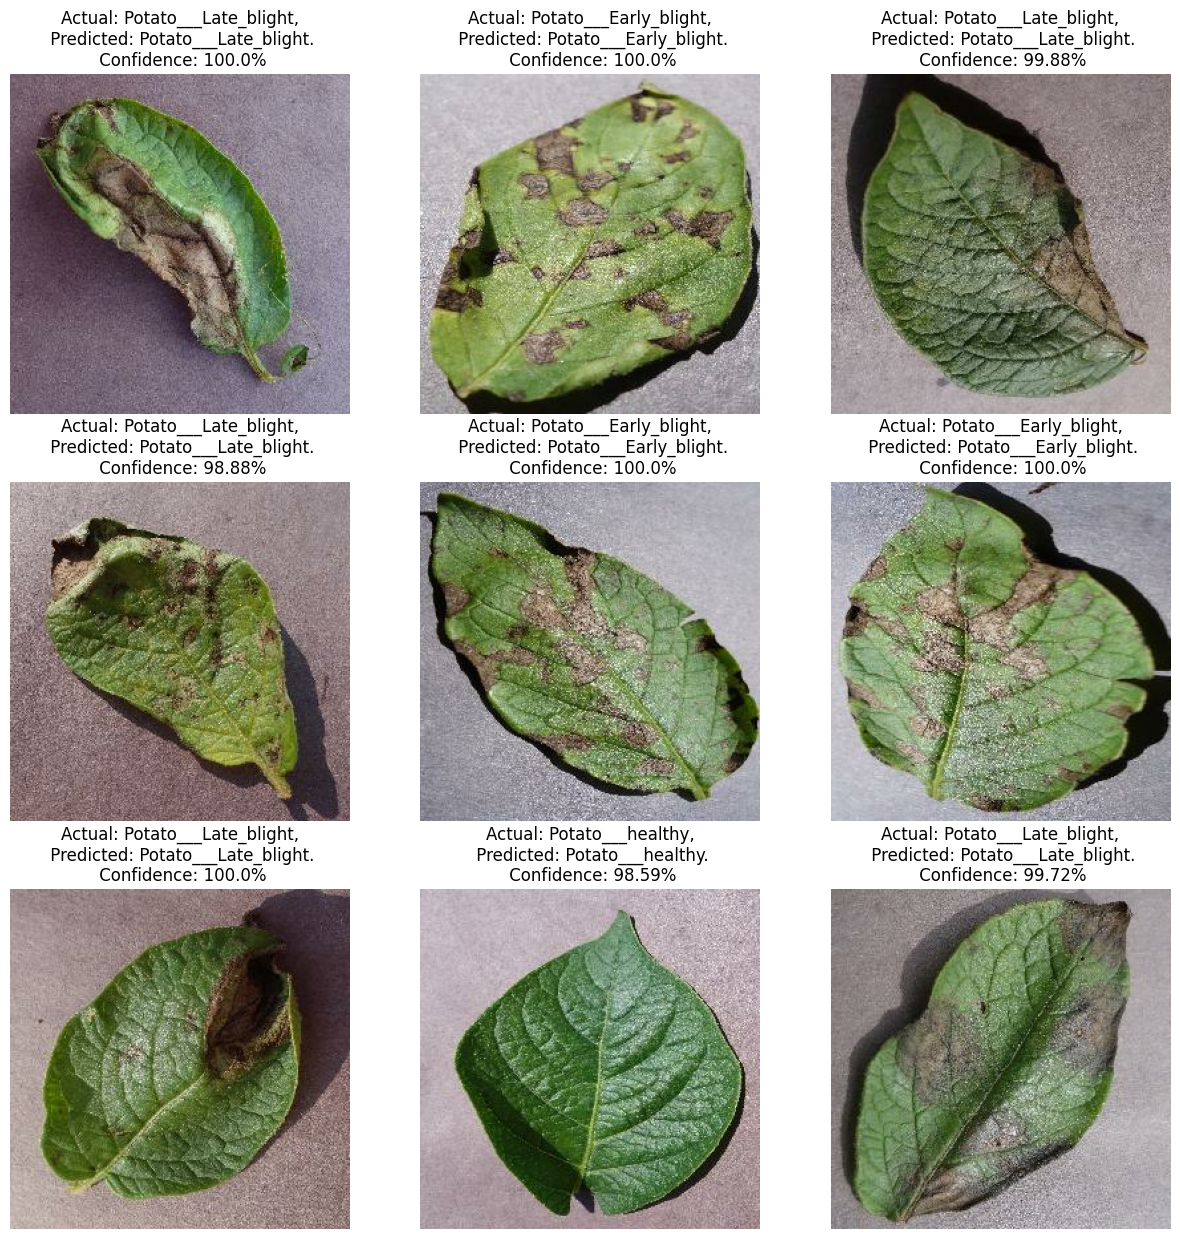

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# **Saving the Model**

In [29]:
model.save('potato_classification_model.keras')

In [ ]:
# Load the saved model
# model = tf.keras.models.load_model('potato_classification_model.keras')